In [1]:
import numpy
import analysis
import lsst.daf.persistence

In [2]:
butler = lsst.daf.persistence.Butler("/home/jbosch/HSC/data/rerun/HSC-1339/baseline")

In [3]:
objs = analysis.ObjectCatalog.read(butler, tract=8522, patch="5,5", filters=("g", "r", "i", "z", "y"))

In [4]:
display = objs.display()

In [5]:
#display.images()

In [6]:
def selectDropouts(catalog):
    r = catalog.r.forced.cmodel.mag
    i = catalog.i.forced.cmodel.mag
    z = catalog.z.forced.cmodel.mag
    conditions = [r-i >= 1.2, i-z <= 0.7, r-i >= 1.5*(i-z) + 1.0,
                  catalog.z.forced.cmodel.flux/catalog.z.forced.cmodel.flux.err > 5.0,
                  catalog.g.forced.cmodel.flux/catalog.g.forced.cmodel.flux.err < 2.0,
                  catalog.detect.is_primary == 0]
    for b in catalog.filters:
        fcat = getattr(catalog, b)
        conditions.extend([
            numpy.logical_not(fcat.flags.pixel.edge),
            numpy.logical_not(fcat.flags.pixel.bad),
            numpy.logical_not(fcat.flags.pixel.saturated.center),
            numpy.logical_not(fcat.flags.pixel.cr.center),
        ])
    mask = numpy.logical_and.reduce(conditions)
    return catalog[mask]

In [7]:
drops = selectDropouts(objs)
display.cmodel(drops, footprints=True)
print len(drops)

5


/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:5: RuntimeWarning: invalid value encountered in greater_equal
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:5: RuntimeWarning: invalid value encountered in less_equal
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:6: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:7: RuntimeWarning: invalid value encountered in less


In [5]:
import matplotlib
%matplotlib inline
matplotlib.pyplot.rcParams["figure.figsize"] = (15, 9)

In [6]:
snrMask = objs.i.meas.cmodel.flux/objs.i.meas.cmodel.flux.err > 5.0
badMask = numpy.logical_and.reduce([
            snrMask,
            objs.i.meas.mag.psf > 25.0,
            objs.i.meas.mag.psf - objs.i.meas.cmodel.mag > 4.0
        ])

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
analysis/objects.py:74: RuntimeWarning: invalid value encountered in greater
  def __gt__(self, other): return operator.gt(self.value, other)
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:5: RuntimeWarning: invalid value encountered in greater


In [8]:
def plotScatter(color, title):
    matplotlib.pyplot.scatter(objs.i.meas.mag.psf.value,
                              objs.i.meas.mag.psf.value - objs.i.meas.cmodel.mag.value,
                              c='k', s=4, alpha=0.5, linewidth=0, label='no cut')
    matplotlib.pyplot.scatter(objs.i.meas.mag.psf.value[snrMask],
                              objs.i.meas.mag.psf.value[snrMask] - objs.i.meas.cmodel.mag.value[snrMask],
                              c=color,
                              s=8, alpha=0.8, linewidth=0, label='snr > 5')
    matplotlib.pyplot.colorbar()
    matplotlib.pyplot.ylim(-0.5, 7.0)
    matplotlib.pyplot.xlim(18.0, 32.0)
    matplotlib.pyplot.legend()
    matplotlib.pyplot.xlabel("psf mag")
    matplotlib.pyplot.xlabel("psf - cmodel")
    matplotlib.pyplot.title(title)

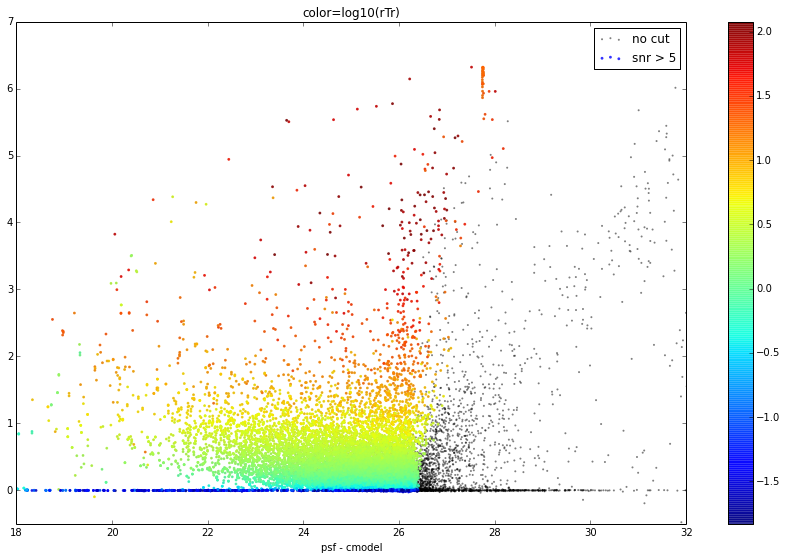

In [9]:
plotScatter(color=numpy.log10(objs.i.meas.cmodel.ellipse.rTr[snrMask]), title="color=log10(rTr)")

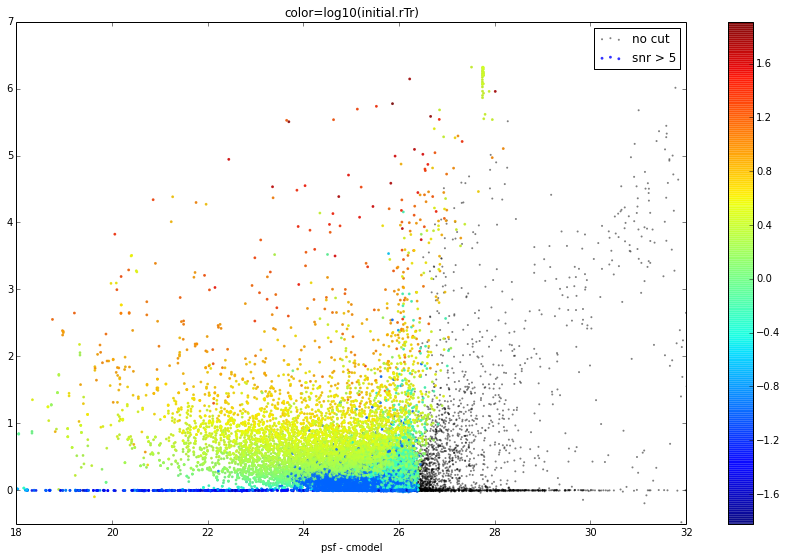

In [12]:
plotScatter(color=numpy.log10(objs.i.meas.cmodel.initial.ellipse.rTr[snrMask]), title="color=log10(initial.rTr)")

In [34]:
display.cmodel(objs[badMask])